# Tarea Final

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from Paquetes.HelperFunctions import violin_plot_numeric, null_percentage, value_counts_all_cols, train_models, validate_models
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold, RepeatedStratifiedKFold
import lightgbm as lgb
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

# %matplotlib notebook

# https://www.kaggle.com/competitions/playground-series-s3e26/data?select=train.csv
# Load Dataset
df = pd.read_csv('data/train.csv')
df.head()


test_real_df = pd.read_csv('data/test.csv')
submission_df = pd.read_csv('data/submission.csv')

In [3]:
df['Status'].value_counts()

Status
C     4965
D     2665
CL     275
Name: count, dtype: int64

## Split Data

In [4]:
from sklearn.model_selection import train_test_split


# Use train_test_split to split the DataFrame
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['Status'])

test_IDs = test_df.id
test_IDs_real = test_real_df.id

# # Drop ID column
train_df.drop(columns=['id'], inplace=True)
test_df.drop(columns=['id'], inplace=True)
test_real_df.drop(columns=['id'], inplace=True)



In [5]:
test_real_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0


## EDA

In [6]:
train_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
1504,2452,D-penicillamine,13178,F,N,N,Y,N,0.6,257.0,3.87,65.0,791.0,91.00,114.0,324.0,9.6,3.0,C
7865,1978,Placebo,20232,F,N,N,N,N,0.6,408.0,3.67,50.0,834.0,110.05,98.0,231.0,11.2,3.0,C
6708,2443,D-penicillamine,19256,F,N,Y,N,N,0.9,308.0,3.69,63.0,696.0,77.50,101.0,344.0,9.8,3.0,C
787,1363,Placebo,16658,F,N,N,N,N,0.7,273.0,3.50,20.0,1637.0,84.00,177.0,228.0,10.6,3.0,C
6412,904,Placebo,22347,M,N,Y,N,N,1.3,420.0,3.58,58.0,604.0,71.30,91.0,253.0,11.5,4.0,D


In [7]:
train_df.shape

(5533, 19)

In [8]:
test_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
2654,3395,D-penicillamine,19295,F,N,Y,N,N,3.4,392.0,3.50,94.0,1080.0,106.95,194.0,228.0,11.0,4.0,D
5415,4032,Placebo,15694,F,N,N,N,N,0.6,302.0,4.16,13.0,1345.0,184.45,184.0,464.0,11.2,2.0,C
6715,3445,Placebo,23445,M,N,Y,N,N,0.6,252.0,3.83,41.0,843.0,65.10,83.0,336.0,11.4,4.0,C
4007,2176,D-penicillamine,12636,F,N,N,N,N,0.6,280.0,4.22,52.0,674.0,71.00,189.0,146.0,10.3,3.0,C
3933,904,D-penicillamine,22388,F,N,Y,N,N,3.8,426.0,3.20,63.0,1440.0,165.85,144.0,422.0,10.0,2.0,D


In [9]:
test_df.shape

(2372, 19)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5533 entries, 1504 to 401
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         5533 non-null   int64  
 1   Drug           5533 non-null   object 
 2   Age            5533 non-null   int64  
 3   Sex            5533 non-null   object 
 4   Ascites        5533 non-null   object 
 5   Hepatomegaly   5533 non-null   object 
 6   Spiders        5533 non-null   object 
 7   Edema          5533 non-null   object 
 8   Bilirubin      5533 non-null   float64
 9   Cholesterol    5533 non-null   float64
 10  Albumin        5533 non-null   float64
 11  Copper         5533 non-null   float64
 12  Alk_Phos       5533 non-null   float64
 13  SGOT           5533 non-null   float64
 14  Tryglicerides  5533 non-null   float64
 15  Platelets      5533 non-null   float64
 16  Prothrombin    5533 non-null   float64
 17  Stage          5533 non-null   float64
 18  Status     

### Check Numerical Cols

In [11]:
numeric_cols = train_df.select_dtypes(include='number')
print(len(numeric_cols.columns))

12


In [12]:
print(type(numeric_cols))

<class 'pandas.core.frame.DataFrame'>


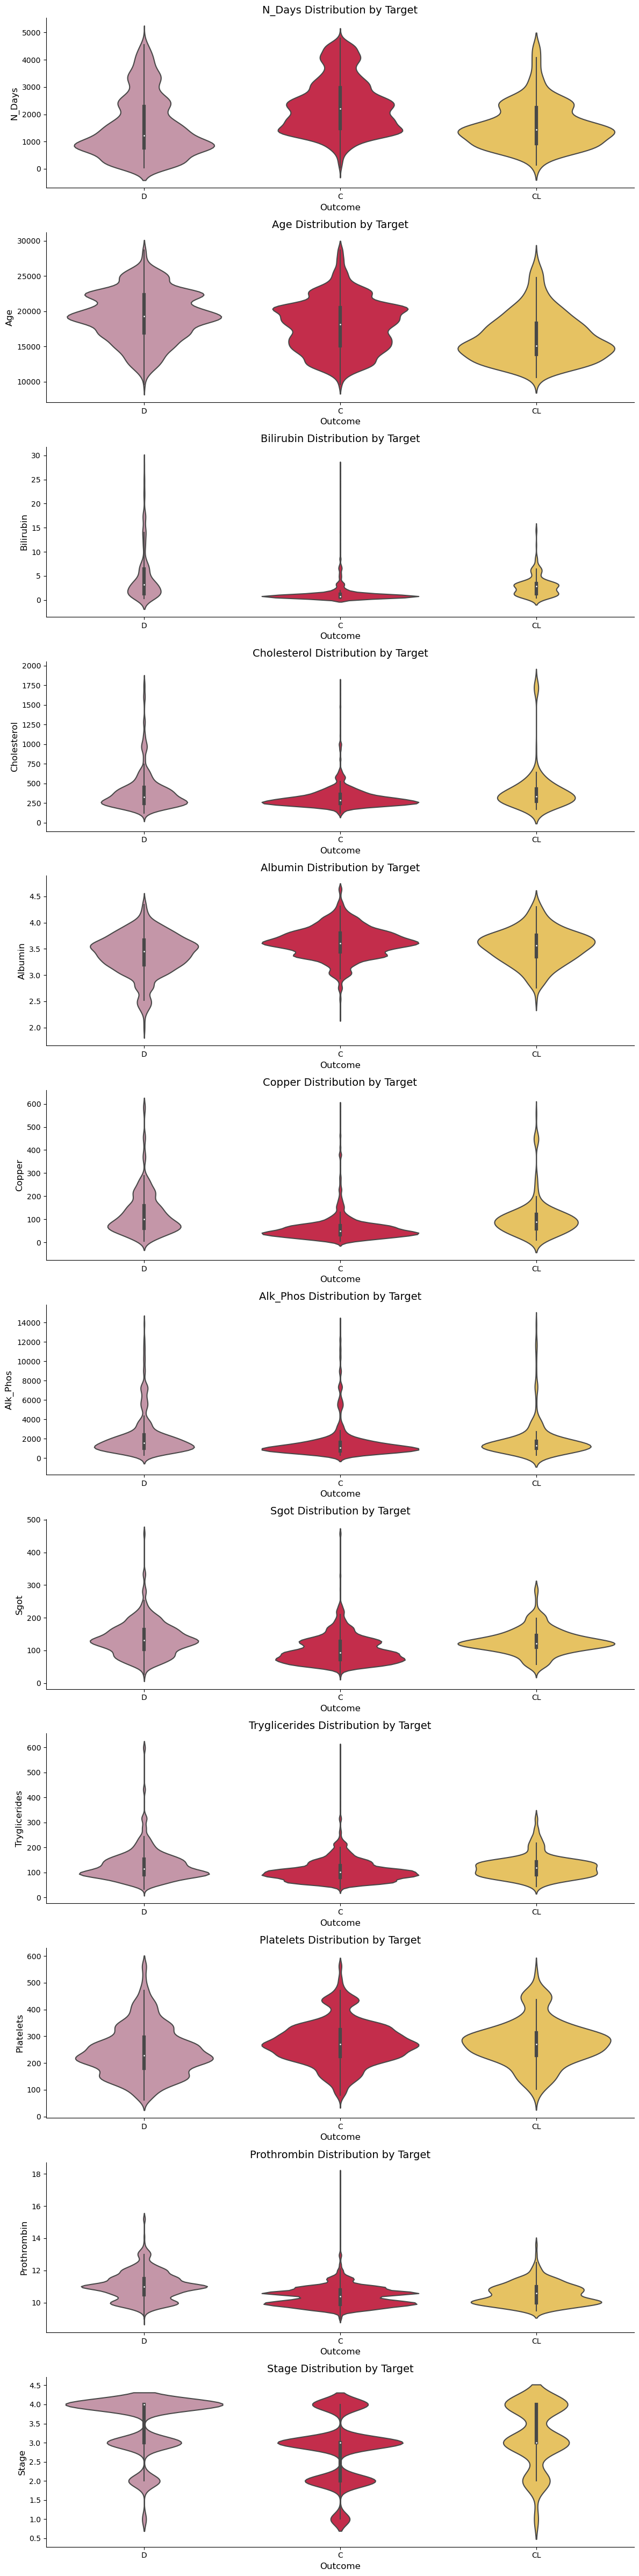

In [13]:
violin_plot_numeric(df, numeric_cols)

### Check Categorical Columns

In [14]:
cat_cols = train_df.select_dtypes(include='object')
cat_cols

,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Status
1504,D-penicillamine,F,N,N,Y,N,C
7865,Placebo,F,N,N,N,N,C
6708,D-penicillamine,F,N,Y,N,N,C
787,Placebo,F,N,N,N,N,C
6412,Placebo,M,N,Y,N,N,D
...,...,...,...,...,...,...,...
5602,D-penicillamine,F,N,N,N,N,C
1305,D-penicillamine,M,N,N,Y,N,D
4433,D-penicillamine,F,N,N,N,N,C
5808,Placebo,F,N,N,N,N,C


In [15]:
value_counts_all_cols(cat_cols)

Value Counts for : Drug
Placebo            2807
D-penicillamine    2726
Name: count, dtype: int64

Value Counts for : Sex
F    5139
M     394
Name: count, dtype: int64

Value Counts for : Ascites
N    5270
Y     263
Name: count, dtype: int64

Value Counts for : Hepatomegaly
Y    2852
N    2681
Name: count, dtype: int64

Value Counts for : Spiders
N    4164
Y    1369
Name: count, dtype: int64

Value Counts for : Edema
N    5015
S     274
Y     244
Name: count, dtype: int64

Value Counts for : Status
C     3475
D     1865
CL     193
Name: count, dtype: int64



* Drug: One-Hot Encoding
* Sex: Label encoding
* Ascites: Label Encoding
* Hepatomegaly: Label Encoding
* Spiders: Label Encoding
* Edema: One-Hot Encoding
* Status: Label Encoding

## Limpieza y Preprocesamiento de Datos

### Identificación y manejo de valores faltantes

In [16]:
null_percentage(train_df)

N_Days: total -> 0, percentage -> 0.00%
Drug: total -> 0, percentage -> 0.00%
Age: total -> 0, percentage -> 0.00%
Sex: total -> 0, percentage -> 0.00%
Ascites: total -> 0, percentage -> 0.00%
Hepatomegaly: total -> 0, percentage -> 0.00%
Spiders: total -> 0, percentage -> 0.00%
Edema: total -> 0, percentage -> 0.00%
Bilirubin: total -> 0, percentage -> 0.00%
Cholesterol: total -> 0, percentage -> 0.00%
Albumin: total -> 0, percentage -> 0.00%
Copper: total -> 0, percentage -> 0.00%
Alk_Phos: total -> 0, percentage -> 0.00%
SGOT: total -> 0, percentage -> 0.00%
Tryglicerides: total -> 0, percentage -> 0.00%
Platelets: total -> 0, percentage -> 0.00%
Prothrombin: total -> 0, percentage -> 0.00%
Stage: total -> 0, percentage -> 0.00%
Status: total -> 0, percentage -> 0.00%


* No null values in the training set

### Codificación de variable categoricas

#### One-Hot Encoding

In [17]:
from Paquetes.HelperFunctions import one_hot_encoding
one_hot_cols = ['Edema']

train_df = one_hot_encoding(train_df, one_hot_cols)
test_df = one_hot_encoding(test_df, one_hot_cols)
test_real_df = one_hot_encoding(test_real_df, one_hot_cols)

In [18]:
test_real_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Edema_N,Edema_S,Edema_Y
0,3839,D-penicillamine,19724,F,N,Y,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0,True,False,False
1,2468,D-penicillamine,14975,F,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0,True,False,False
2,51,Placebo,13149,F,N,Y,N,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0,False,False,True
3,2330,D-penicillamine,20510,F,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0,True,False,False
4,1615,D-penicillamine,21904,F,N,Y,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0,True,False,False


#### Label Encoding

In [19]:
le_cols = ['Drug','Sex','Ascites', 'Hepatomegaly', 'Spiders', 'Status']
value_counts_all_cols(train_df, le_cols)

Value Counts for : Drug
Placebo            2807
D-penicillamine    2726
Name: count, dtype: int64

Value Counts for : Sex
F    5139
M     394
Name: count, dtype: int64

Value Counts for : Ascites
N    5270
Y     263
Name: count, dtype: int64

Value Counts for : Hepatomegaly
Y    2852
N    2681
Name: count, dtype: int64

Value Counts for : Spiders
N    4164
Y    1369
Name: count, dtype: int64

Value Counts for : Status
C     3475
D     1865
CL     193
Name: count, dtype: int64



In [20]:
from Paquetes.HelperFunctions import label_encoding


le_cols = ['Drug','Sex','Ascites', 'Hepatomegaly', 'Spiders', 'Status']
le_cols_test_real = ['Drug','Sex','Ascites', 'Hepatomegaly', 'Spiders']
cols_dict = {'Drug': {'D-penicillamine': 0, 'Placebo': 1}, 'Sex': {"F":0,"M":1}, 'Ascites':{'N':0,'Y':1}, 'Hepatomegaly': {'N':0,'Y':1}, 'Spiders': {'N':0,'Y':1}, 'Status': {'C':0,'D':1,'CL':2} }
cols_dict_test_real = {'Drug': {'D-penicillamine': 0, 'Placebo': 1}, 'Sex': {"F":0,"M":1}, 'Ascites':{'N':0,'Y':1}, 'Hepatomegaly': {'N':0,'Y':1}, 'Spiders': {'N':0,'Y':1} }
label_encoding(train_df, le_cols, cols_dict)
label_encoding(test_df, le_cols, cols_dict)
label_encoding(test_real_df, le_cols_test_real, cols_dict_test_real)


,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Edema_N,Edema_S,Edema_Y
0,3839,0,19724,0,0,1,0,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0,True,False,False
1,2468,0,14975,0,0,0,0,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0,True,False,False
2,51,1,13149,0,0,1,0,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0,False,False,True
3,2330,0,20510,0,0,0,0,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0,True,False,False
4,1615,0,21904,0,0,1,0,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,2870,1,12279,0,0,0,0,1.3,302.0,3.43,75.0,1345.0,145.00,44.0,181.0,10.6,3.0,True,False,False
5267,1770,1,24803,0,0,0,0,0.5,219.0,4.09,121.0,663.0,79.05,94.0,311.0,9.7,3.0,True,False,False
5268,3707,0,16990,0,0,1,0,0.8,315.0,4.09,13.0,1637.0,170.50,70.0,426.0,10.9,3.0,True,False,False
5269,1216,1,11773,0,0,0,0,0.7,329.0,3.80,52.0,678.0,57.00,126.0,306.0,10.2,1.0,True,False,False


In [21]:
le_cols = ['Drug','Sex','Ascites', 'Hepatomegaly', 'Spiders', 'Status']
value_counts_all_cols(test_real_df, le_cols_test_real)

print(len(train_df))

Value Counts for : Drug
1    2694
0    2577
Name: count, dtype: int64

Value Counts for : Sex
0    4877
1     394
Name: count, dtype: int64

Value Counts for : Ascites
0    5027
1     244
Name: count, dtype: int64

Value Counts for : Hepatomegaly
1    2730
0    2541
Name: count, dtype: int64

Value Counts for : Spiders
0    3972
1    1299
Name: count, dtype: int64

5533


In [22]:
test_real_df.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Edema_N,Edema_S,Edema_Y
0,3839,0,19724,0,0,1,0,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0,True,False,False
1,2468,0,14975,0,0,0,0,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0,True,False,False
2,51,1,13149,0,0,1,0,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0,False,False,True
3,2330,0,20510,0,0,0,0,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0,True,False,False
4,1615,0,21904,0,0,1,0,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0,True,False,False


In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5533 entries, 1504 to 401
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         5533 non-null   int64  
 1   Drug           5533 non-null   int64  
 2   Age            5533 non-null   int64  
 3   Sex            5533 non-null   int64  
 4   Ascites        5533 non-null   int64  
 5   Hepatomegaly   5533 non-null   int64  
 6   Spiders        5533 non-null   int64  
 7   Bilirubin      5533 non-null   float64
 8   Cholesterol    5533 non-null   float64
 9   Albumin        5533 non-null   float64
 10  Copper         5533 non-null   float64
 11  Alk_Phos       5533 non-null   float64
 12  SGOT           5533 non-null   float64
 13  Tryglicerides  5533 non-null   float64
 14  Platelets      5533 non-null   float64
 15  Prothrombin    5533 non-null   float64
 16  Stage          5533 non-null   float64
 17  Status         5533 non-null   int64  
 18  Edema_N    

## Modelado y Evaluación

### Selección de Características

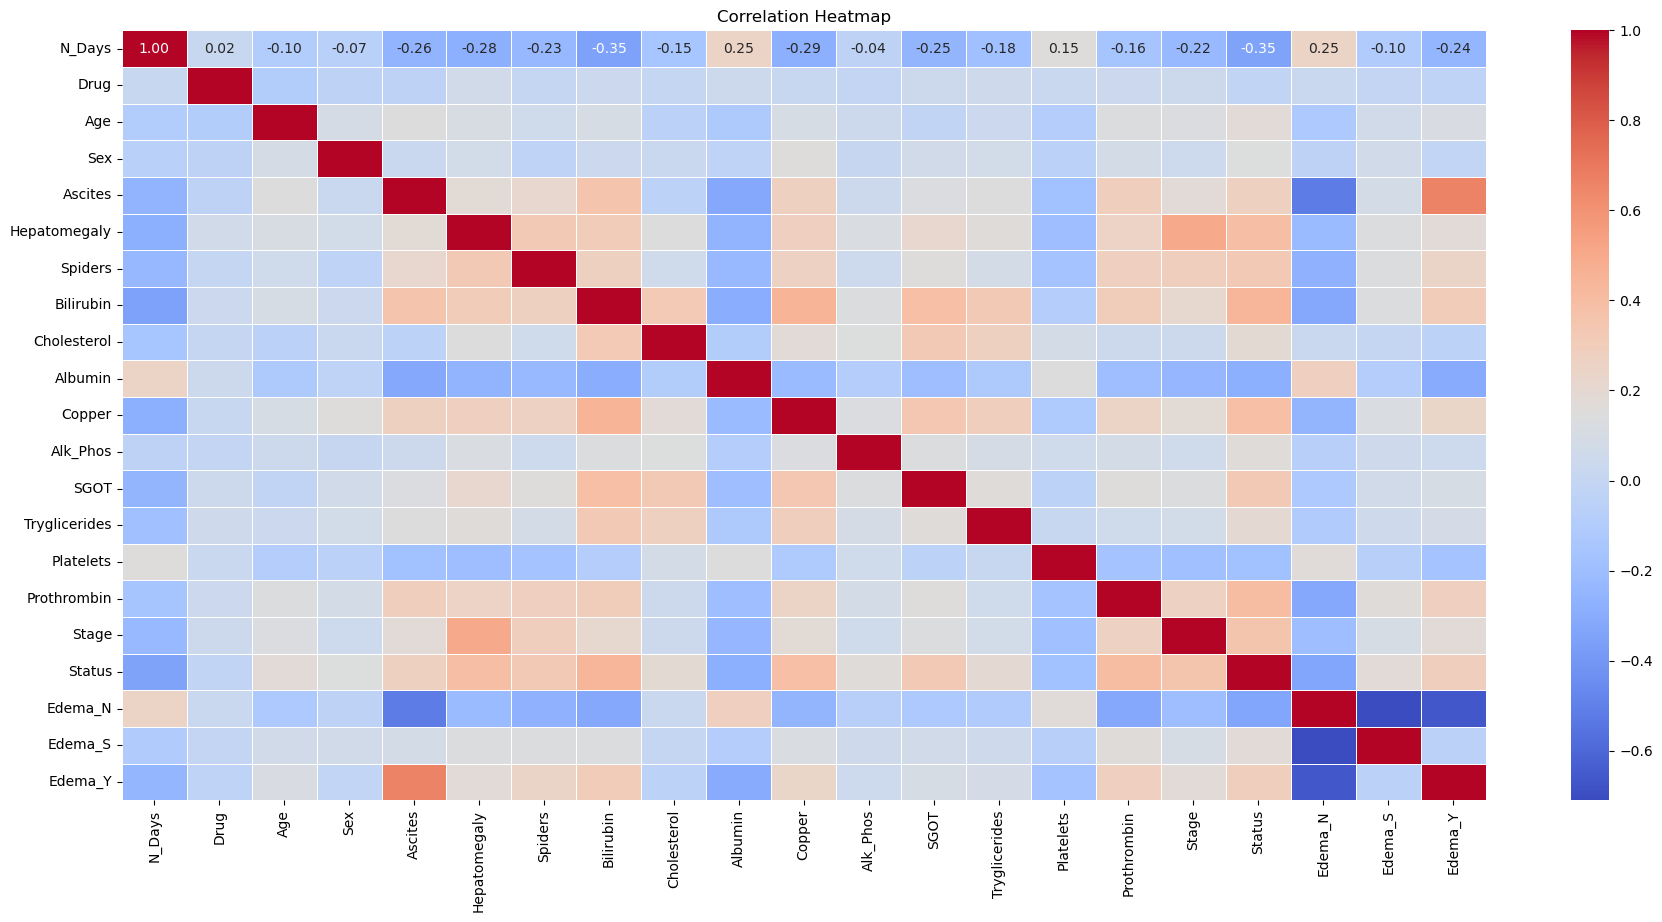

In [24]:
from Paquetes.HelperFunctions import corr_heatmap

corr = corr_heatmap(train_df)

In [25]:
LABEL = "Status"
CAT_FEATS = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
NUM_FEATS = [x for x in train_df.columns if x not in CAT_FEATS and x != LABEL]

### Feature Engineering

In [26]:

class DiagnosisDateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diagnosis_Date'] = X['Age'] - X['N_Days']
        return X
    
class AgeYearsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Age_Years'] = round(X['Age'] / 365.25).astype("int16")
        return X

class AgeGroupsTransformer(BaseEstimator, TransformerMixin):
    """Older people might be hit harder (interaction) by health issues. Also can cover lifestyle influences, i.e.
    alcohol consumption etc."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # Use years from above, min=26, max=78
        X['Age_Group'] = pd.cut(X['Age_Years'], bins=[19, 29, 49, 64, 99], labels = [0, 1, 2, 3]).astype('int16')
        return X

class BilirubinAlbuminTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Bilirubin_Albumin'] = X['Bilirubin'] * X['Albumin']
        return X

class DrugEffectivenessTransformer(BaseEstimator, TransformerMixin):
    # Placeholder concept, assuming 'Bilirubin' improvement is a measure of effectiveness
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Drug_Effectiveness'] = X['Drug'] * X['Bilirubin']
        return X

class SymptomScoreTransformer(BaseEstimator, TransformerMixin):
    # From data set explanations above let's add all the "bad" symptoms
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
        symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema_N', 'Edema_S', 'Edema_Y']
        X['Symptom_Score'] = X[symptom_columns].sum(axis=1)
        return X
    
class SymptomCatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema_N', 'Edema_S', 'Edema_Y']
        self.encoder = OneHotEncoder(handle_unknown='ignore')

    def fit(self, X, y=None):
        X_copy = X.copy()
        symptom_scores = X_copy[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        self.encoder.fit(symptom_scores.values.reshape(-1, 1))
        return self

    def transform(self, X):
        X_transformed = X.copy()
        symptom_scores = X_transformed[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        encoded_features = self.encoder.transform(symptom_scores.values.reshape(-1, 1)).toarray().astype("int8")
        encoded_feature_names = self.encoder.get_feature_names_out(input_features=['Symptom_Score'])
        # Drop the original symptom columns and add the new encoded features
        # X_transformed.drop(columns=self.symptom_columns, inplace=True)
        X_transformed[encoded_feature_names] = pd.DataFrame(encoded_features, index=X_transformed.index)
        
        return X_transformed


class LiverFunctionTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        liver_columns = ['Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT']
        X['Liver_Function_Index'] = X[liver_columns].mean(axis=1)
        return X

class RiskScoreTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Risk_Score'] = X['Bilirubin'] + X['Albumin'] - X['Alk_Phos']
        return X

class TimeFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diag_Year'] = (X['N_Days'] / 365).astype(int)
        X['Diag_Month'] = ((X['N_Days'] % 365) / 30).astype(int)
        return X
    
class ScalingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.num_feats = NUM_FEATS + ['Diagnosis_Date', 'Age_Years', 'Bilirubin_Albumin', 'Drug_Effectiveness', 
                                      'Symptom_Score', 'Liver_Function_Index', 'Risk_Score', 'Diag_Year', 'Diag_Month']

    def fit(self, X, y=None):
        self.scaler.fit(X[self.num_feats])
        return self

    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.num_feats] = self.scaler.transform(X_scaled[self.num_feats])
        return X_scaled

# Define the pipeline
pipeline = Pipeline([
    ('diagnosis_date', DiagnosisDateTransformer()),
    ('age_years', AgeYearsTransformer()),
    ('age_groups', AgeGroupsTransformer()),
    ('bilirubin_albumin', BilirubinAlbuminTransformer()),
    ('drug_effectiveness', DrugEffectivenessTransformer()),
    ('symptom_score', SymptomScoreTransformer()),
    ('symptom_cat_score', SymptomCatTransformer()),
    ('liver_function', LiverFunctionTransformer()),
    ('risk_score', RiskScoreTransformer()),
    ('time_features', TimeFeaturesTransformer()),
    #('scaling', ScalingTransformer()),
    # ... ?
])

# Apply the pipeline to your dataframes
train_df_mod = pipeline.fit_transform(train_df)
test_df_mod = pipeline.transform(test_df)
test_df_real_mod = pipeline.transform(test_real_df)
train_df_mod['Symptom_Score'] = pd.to_numeric(train_df_mod['Symptom_Score'], errors='coerce')
test_df_mod['Symptom_Score'] = pd.to_numeric(test_df_mod['Symptom_Score'], errors='coerce')
test_df_real_mod['Symptom_Score'] = pd.to_numeric(test_df_real_mod['Symptom_Score'], errors='coerce')

# Update the CAT_FEATS
CAT_FEATS = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage', #old
             'Age_Group', 'Symptom_Score'] # new 
# Update the NUM_FEATS ????

In [27]:
train_df_mod.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y,Diagnosis_Date,Age_Years,Age_Group,Bilirubin_Albumin,Drug_Effectiveness,Symptom_Score,Symptom_Score_000FalseFalseTrue,Symptom_Score_000FalseTrueFalse,Symptom_Score_000TrueFalseFalse,Symptom_Score_001FalseFalseTrue,Symptom_Score_001FalseTrueFalse,Symptom_Score_001TrueFalseFalse,Symptom_Score_010FalseFalseTrue,Symptom_Score_010FalseTrueFalse,Symptom_Score_010TrueFalseFalse,Symptom_Score_011FalseFalseTrue,Symptom_Score_011FalseTrueFalse,Symptom_Score_011TrueFalseFalse,Symptom_Score_100FalseFalseTrue,Symptom_Score_100FalseTrueFalse,Symptom_Score_100TrueFalseFalse,Symptom_Score_101FalseFalseTrue,Symptom_Score_101TrueFalseFalse,Symptom_Score_110FalseFalseTrue,Symptom_Score_110FalseTrueFalse,Symptom_Score_110TrueFalseFalse,Symptom_Score_111FalseFalseTrue,Symptom_Score_111FalseTrueFalse,Symptom_Score_111TrueFalseFalse,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month
1504,2452,0,13178,0,0,0,1,0.6,257.0,3.87,65.0,791.0,91.00,114.0,324.0,9.6,3.0,0,True,False,False,10726,36,1,2.322,0.0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,221.6175,-786.53,6,8
7865,1978,1,20232,0,0,0,0,0.6,408.0,3.67,50.0,834.0,110.05,98.0,231.0,11.2,3.0,0,True,False,False,18254,55,2,2.202,0.6,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,237.0800,-829.73,5,5
6708,2443,0,19256,0,0,1,0,0.9,308.0,3.69,63.0,696.0,77.50,101.0,344.0,9.8,3.0,0,True,False,False,16813,53,2,3.321,0.0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,194.5225,-691.41,6,8
787,1363,1,16658,0,0,0,0,0.7,273.0,3.50,20.0,1637.0,84.00,177.0,228.0,10.6,3.0,0,True,False,False,15295,46,1,2.450,0.7,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,431.3000,-1632.80,3,8
6412,904,1,22347,1,0,1,0,1.3,420.0,3.58,58.0,604.0,71.30,91.0,253.0,11.5,4.0,2,True,False,False,21443,61,2,4.654,1.3,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,170.0450,-599.12,2,5


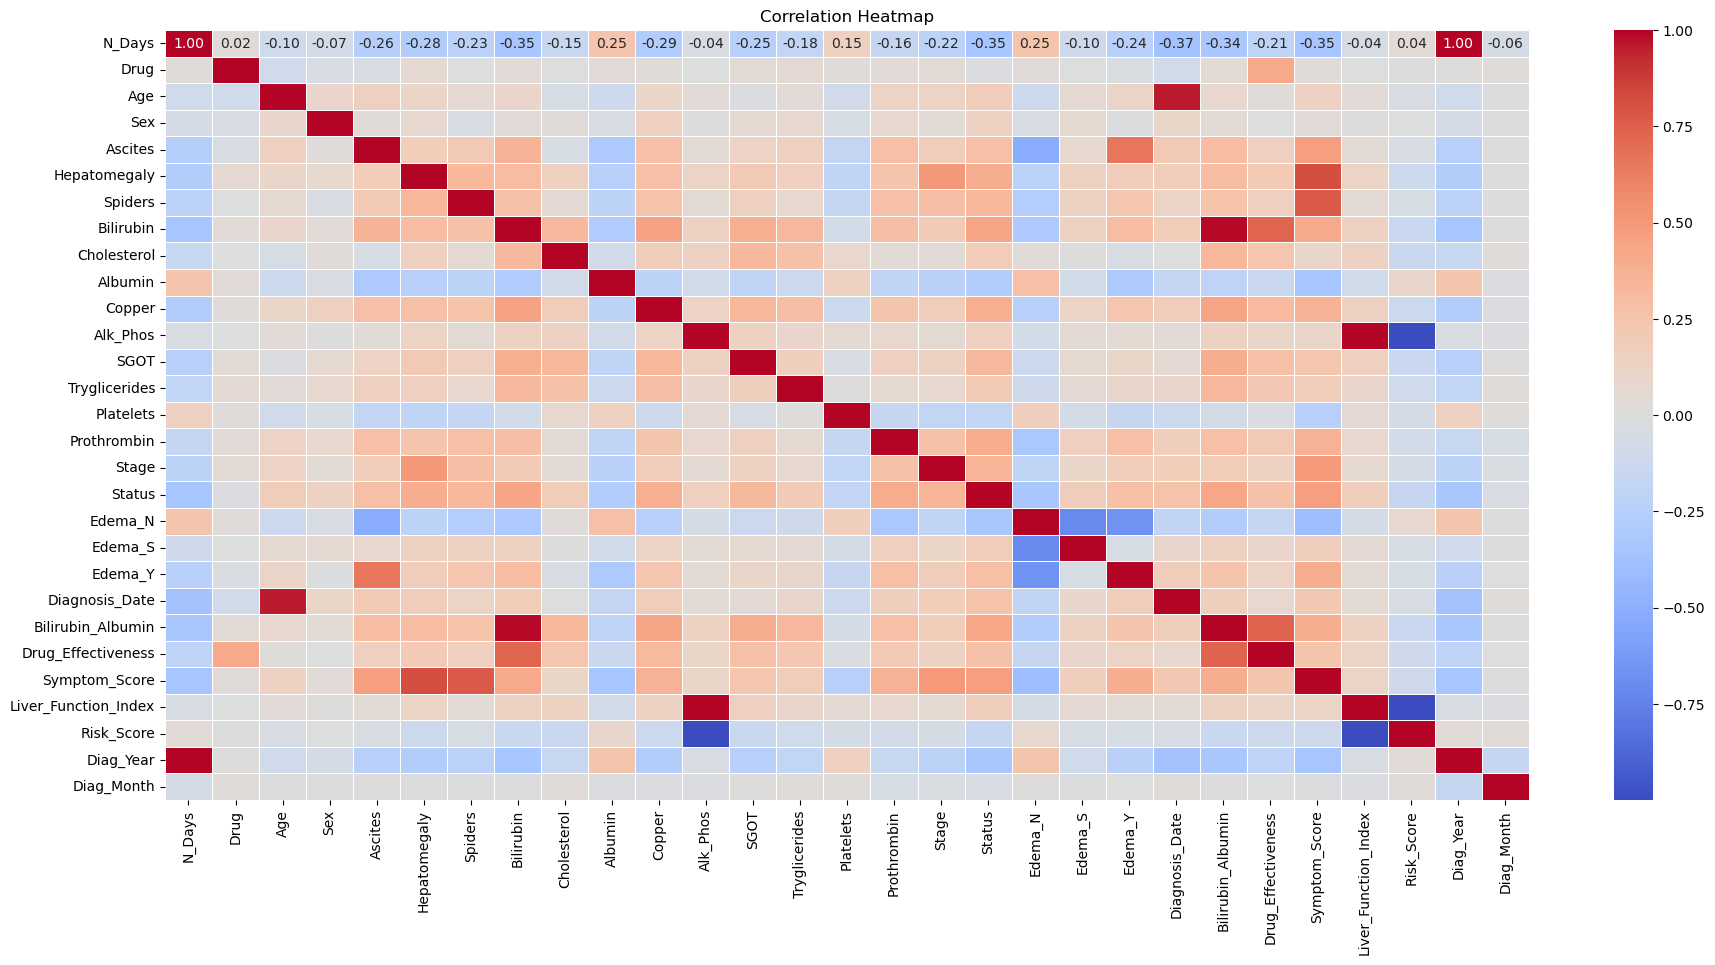

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y,Diagnosis_Date,Bilirubin_Albumin,Drug_Effectiveness,Symptom_Score,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month
N_Days,1.000000,0.017211,-0.099972,-0.067752,-0.259378,-0.278166,-0.231921,-0.351369,-0.153007,0.250586,-0.286285,-0.035818,-0.253103,-0.184588,0.152076,-0.160516,-0.224821,-0.348958,0.247751,-0.102991,-0.242678,-0.372715,-0.336114,-0.209287,-0.351236,-0.042986,0.035151,0.995459,-0.062289
Drug,0.017211,1.000000,-0.095305,-0.040602,-0.041498,0.067362,-0.001274,0.035642,-0.000664,0.038990,0.016328,-0.007093,0.042376,0.057579,0.028033,0.037990,0.039662,-0.021658,0.025803,-0.006674,-0.029556,-0.093693,0.045812,0.415098,0.028985,-0.005871,0.007176,0.015310,0.020490
Age,-0.099972,-0.095305,1.000000,0.096443,0.149506,0.105965,0.063723,0.099501,-0.053260,-0.116216,0.104236,0.038756,-0.015783,0.037126,-0.086670,0.132508,0.129334,0.172021,-0.128112,0.064814,0.113277,0.960558,0.081449,0.021091,0.133993,0.038363,-0.038583,-0.099047,0.001551
Sex,-0.067752,-0.040602,0.096443,1.000000,0.030624,0.072999,-0.034991,0.037711,0.027499,-0.033013,0.152539,0.007027,0.070094,0.076041,-0.050104,0.080243,0.045026,0.138294,-0.041287,0.066368,-0.011552,0.108880,0.041323,-0.001874,0.033298,0.008909,-0.006958,-0.067229,0.001742
Ascites,-0.259378,-0.041498,0.149506,0.030624,1.000000,0.182601,0.212448,0.365057,-0.047017,-0.317391,0.275511,0.041963,0.128137,0.149333,-0.178787,0.287465,0.175663,0.278387,-0.523053,0.078209,0.659461,0.211922,0.312200,0.163531,0.472289,0.045841,-0.041282,-0.257570,0.010781
Hepatomegaly,-0.278166,0.067362,0.105965,0.072999,0.182601,1.000000,0.331327,0.310875,0.150573,-0.257575,0.280457,0.118938,0.212464,0.159671,-0.202156,0.255594,0.500755,0.395771,-0.222218,0.132962,0.174782,0.176567,0.303467,0.207590,0.813496,0.124610,-0.118378,-0.273656,-0.015556
Spiders,-0.231921,-0.001274,0.063723,-0.034991,0.212448,0.331327,1.000000,0.273312,0.060775,-0.222886,0.261236,0.049946,0.155482,0.080812,-0.166503,0.280294,0.289614,0.329129,-0.270071,0.133604,0.241997,0.124246,0.263180,0.160365,0.766610,0.054338,-0.049438,-0.228438,-0.009966
Bilirubin,-0.351369,0.035642,0.099501,0.037711,0.365057,0.310875,0.273312,1.000000,0.321751,-0.295647,0.446880,0.135529,0.389122,0.327713,-0.082577,0.294388,0.205600,0.441785,-0.318363,0.135786,0.308208,0.190997,0.988802,0.729048,0.418902,0.147174,-0.133562,-0.347616,0.002643
Cholesterol,-0.153007,-0.000664,-0.053260,0.027499,-0.047017,0.150573,0.060775,0.321751,1.000000,-0.093149,0.174634,0.139237,0.331406,0.272745,0.082957,0.040605,0.040870,0.190689,0.028411,0.004507,-0.045071,-0.006909,0.334401,0.237593,0.109175,0.147999,-0.138629,-0.153883,0.026248
Albumin,0.250586,0.038990,-0.116216,-0.033013,-0.317391,-0.257575,-0.222886,-0.295647,-0.093149,1.000000,-0.219808,-0.086664,-0.198175,-0.122301,0.146412,-0.199005,-0.240530,-0.287421,0.279907,-0.085868,-0.306394,-0.178419,-0.210046,-0.134668,-0.349034,-0.091924,0.086265,0.249558,-0.018248


In [28]:
corr_heatmap(train_df_mod)

In [29]:
label_encoder = LabelEncoder()
def tsne_with_feature_selection_and_pca(data, num_feats, target_column, n_components=2, top_n_features=10, pca_components=None):
    """
    Select top features based on feature importance, optionally apply PCA, and then use t-SNE for visualization.

    Parameters:
    data (DataFrame): The input data.
    num_feats (list): List of numerical feature column names.
    target_column (str): The name of the target column.
    n_components (int): Number of dimensions for t-SNE (2 or 3). Default is 2.
    top_n_features (int): Number of top features to select based on importance. Default is 10.
    pca_components (int or None): Number of PCA components to retain before applying t-SNE. If None, PCA is not applied.
    """
    
    global label_encoder
    
    # Standardizing the numerical features
    scaler = StandardScaler()
    numerical_data_scaled = scaler.fit_transform(data[num_feats])

    # Random Forest for feature importances
    rf = RandomForestClassifier(random_state=42)
    rf.fit(numerical_data_scaled, data[target_column])
    importances = rf.feature_importances_

    # Selecting top_n_features
    indices = np.argsort(importances)[-top_n_features:]
    selected_features = [num_feats[i] for i in indices]

    # Data for t-SNE
    tsne_data = numerical_data_scaled[:, indices]

    # Optionally applying PCA
    if pca_components is not None and pca_components < len(selected_features):
        pca = PCA(n_components=pca_components)
        tsne_data = pca.fit_transform(tsne_data)

    # Applying t-SNE
    tsne = TSNE(n_components=n_components, learning_rate='auto', init='random', perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(tsne_data)

    # Creating a DataFrame for the t-SNE results
    tsne_df = pd.DataFrame(tsne_results, columns=[f'Component {i+1}' for i in range(n_components)])
    tsne_df[target_column] = label_encoder.inverse_transform(data[target_column].values)

    # Visualizing using Plotly
    if n_components == 3:
        fig = px.scatter_3d(tsne_df, x='Component 1', y='Component 2', z='Component 3', color=target_column)
    else:
        fig = px.scatter(tsne_df, x='Component 1', y='Component 2', color=target_column)
    
    fig.update_layout(width=800, height=600)
    fig.show()

train_df_red = train_df_mod
# tsne_with_feature_selection_and_pca(train_df_red, NUM_FEATS, LABEL, n_components=3, top_n_features=10, pca_components=None)

In [30]:
# Features to combine 
# All
#df_train_pca = df_train_mod.drop([LABEL], axis=1)
#df_test_pca = df_test_mod

# Numerical feats
df_train_pca = train_df_mod[NUM_FEATS]
df_test_pca = test_df_mod[NUM_FEATS]
test_real_df_pca = test_df_real_mod[NUM_FEATS]

# Some, the feats here are taken iteratively from previous runs
#FEATS = ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days']
#PCA_FEATS = [c for c in df_train_mod.drop(LABEL, axis=1).columns.values if c not in FEATS]
#df_train_pca = df_train_mod[PCA_FEATS]
#df_test_pca = df_test_mod[PCA_FEATS]

pca = PCA(n_components=3)
df_train_pca = pca.fit_transform(df_train_pca)
df_test_pca = pca.transform(df_test_pca)
test_real_df_pca = pca.transform(test_real_df_pca)

print(f"Explained variance per component: {np.round(pca.explained_variance_ratio_, 1)}")

Explained variance per component: [0.7 0.2 0.1]


In [31]:
eps_expl_var_treshold = 0
n_pcas = np.sum(np.round(pca.explained_variance_ratio_, 3) > eps_expl_var_treshold)
pca_c_names = [f"PCA_{i}" for i in range(n_pcas)]
print(f"PCA column names: {pca_c_names}")
train_df_mod[pca_c_names] = df_train_pca[:,0:n_pcas]
test_df_mod[pca_c_names] = df_test_pca[:,0:n_pcas]
test_df_real_mod[pca_c_names] = test_real_df_pca[:,0:n_pcas]

PCA column names: ['PCA_0', 'PCA_1', 'PCA_2']


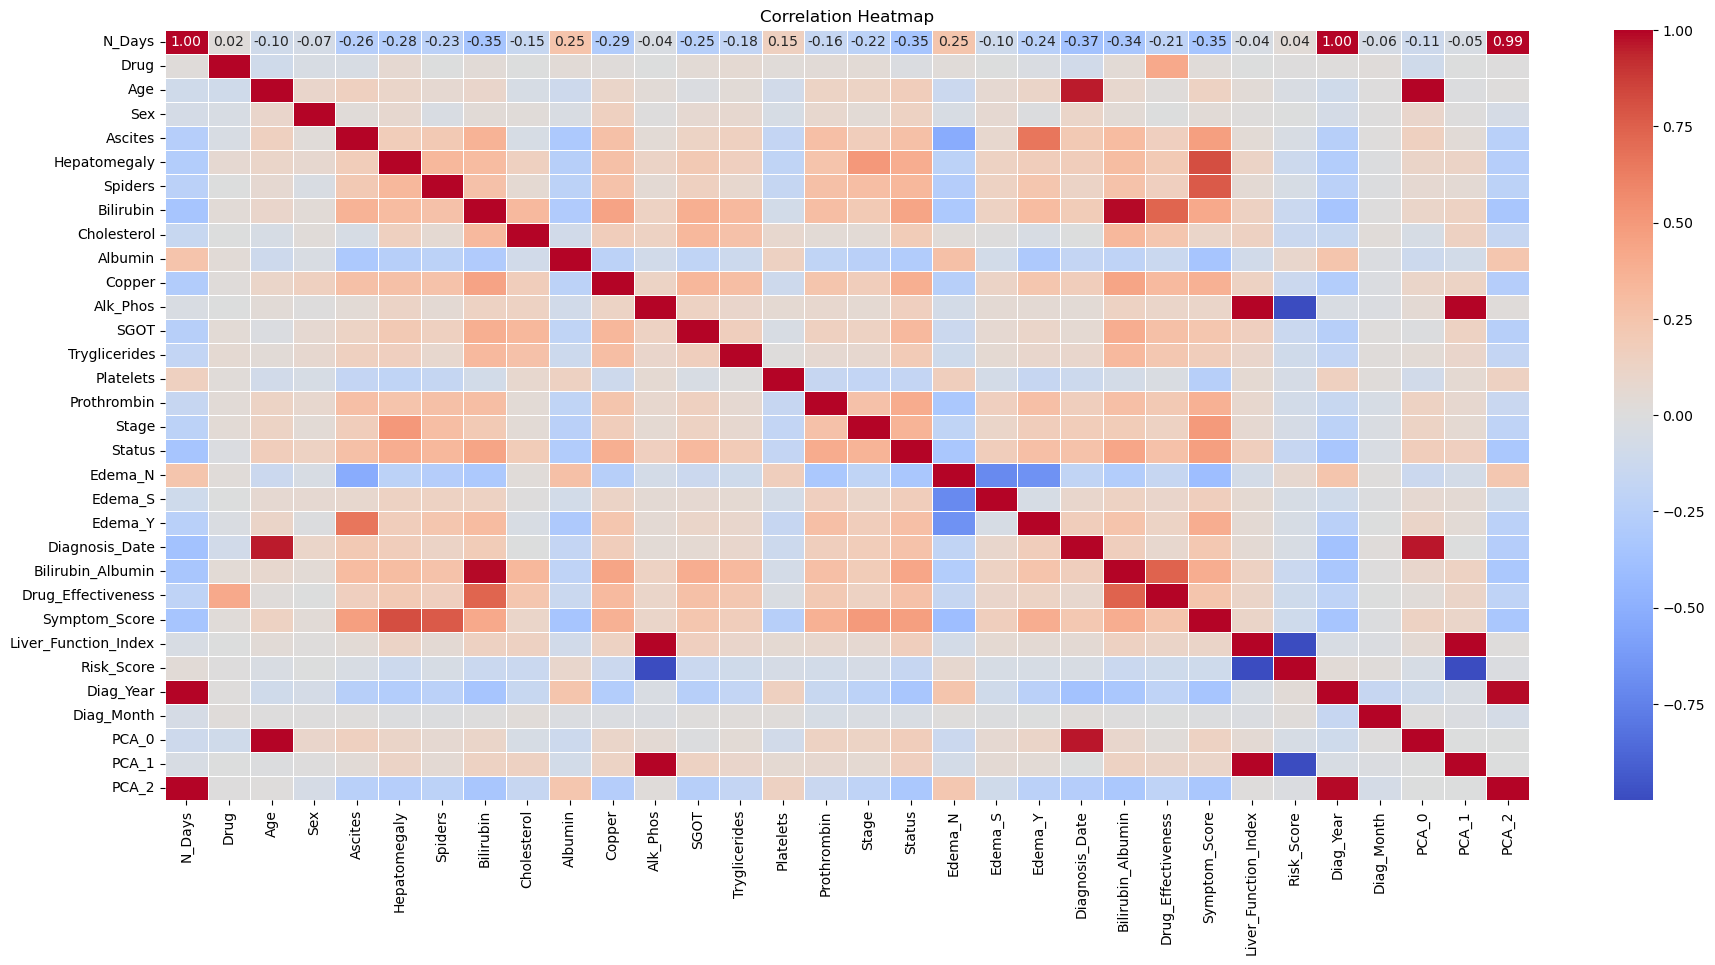

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y,Diagnosis_Date,Bilirubin_Albumin,Drug_Effectiveness,Symptom_Score,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month,PCA_0,PCA_1,PCA_2
N_Days,1.000000,0.017211,-0.099972,-0.067752,-0.259378,-0.278166,-0.231921,-0.351369,-0.153007,0.250586,-0.286285,-0.035818,-0.253103,-0.184588,0.152076,-0.160516,-0.224821,-0.348958,0.247751,-0.102991,-0.242678,-0.372715,-0.336114,-0.209287,-0.351236,-0.042986,0.035151,0.995459,-0.062289,-1.101738e-01,-4.682728e-02,9.927904e-01
Drug,0.017211,1.000000,-0.095305,-0.040602,-0.041498,0.067362,-0.001274,0.035642,-0.000664,0.038990,0.016328,-0.007093,0.042376,0.057579,0.028033,0.037990,0.039662,-0.021658,0.025803,-0.006674,-0.029556,-0.093693,0.045812,0.415098,0.028985,-0.005871,0.007176,0.015310,0.020490,-9.541186e-02,-2.161412e-03,6.599636e-03
Age,-0.099972,-0.095305,1.000000,0.096443,0.149506,0.105965,0.063723,0.099501,-0.053260,-0.116216,0.104236,0.038756,-0.015783,0.037126,-0.086670,0.132508,0.129334,0.172021,-0.128112,0.064814,0.113277,0.960558,0.081449,0.021091,0.133993,0.038363,-0.038583,-0.099047,0.001551,9.998530e-01,-1.420956e-02,9.587917e-03
Sex,-0.067752,-0.040602,0.096443,1.000000,0.030624,0.072999,-0.034991,0.037711,0.027499,-0.033013,0.152539,0.007027,0.070094,0.076041,-0.050104,0.080243,0.045026,0.138294,-0.041287,0.066368,-0.011552,0.108880,0.041323,-0.001874,0.033298,0.008909,-0.006958,-0.067229,0.001742,9.705242e-02,2.947908e-03,-5.771501e-02
Ascites,-0.259378,-0.041498,0.149506,0.030624,1.000000,0.182601,0.212448,0.365057,-0.047017,-0.317391,0.275511,0.041963,0.128137,0.149333,-0.178787,0.287465,0.175663,0.278387,-0.523053,0.078209,0.659461,0.211922,0.312200,0.163531,0.472289,0.045841,-0.041282,-0.257570,0.010781,1.524236e-01,3.796153e-02,-2.425408e-01
Hepatomegaly,-0.278166,0.067362,0.105965,0.072999,0.182601,1.000000,0.331327,0.310875,0.150573,-0.257575,0.280457,0.118938,0.212464,0.159671,-0.202156,0.255594,0.500755,0.395771,-0.222218,0.132962,0.174782,0.176567,0.303467,0.207590,0.813496,0.124610,-0.118378,-0.273656,-0.015556,1.101726e-01,1.179385e-01,-2.634442e-01
Spiders,-0.231921,-0.001274,0.063723,-0.034991,0.212448,0.331327,1.000000,0.273312,0.060775,-0.222886,0.261236,0.049946,0.155482,0.080812,-0.166503,0.280294,0.289614,0.329129,-0.270071,0.133604,0.241997,0.124246,0.263180,0.160365,0.766610,0.054338,-0.049438,-0.228438,-0.009966,6.660589e-02,5.035648e-02,-2.243921e-01
Bilirubin,-0.351369,0.035642,0.099501,0.037711,0.365057,0.310875,0.273312,1.000000,0.321751,-0.295647,0.446880,0.135529,0.389122,0.327713,-0.082577,0.294388,0.205600,0.441785,-0.318363,0.135786,0.308208,0.190997,0.988802,0.729048,0.418902,0.147174,-0.133562,-0.347616,0.002643,1.046469e-01,1.364355e-01,-3.380066e-01
Cholesterol,-0.153007,-0.000664,-0.053260,0.027499,-0.047017,0.150573,0.060775,0.321751,1.000000,-0.093149,0.174634,0.139237,0.331406,0.272745,0.082957,0.040605,0.040870,0.190689,0.028411,0.004507,-0.045071,-0.006909,0.334401,0.237593,0.109175,0.147999,-0.138629,-0.153883,0.026248,-4.989112e-02,1.463996e-01,-1.583654e-01
Albumin,0.250586,0.038990,-0.116216,-0.033013,-0.317391,-0.257575,-0.222886,-0.295647,-0.093149,1.000000,-0.219808,-0.086664,-0.198175,-0.122301,0.146412,-0.199005,-0.240530,-0.287421,0.279907,-0.085868,-0.306394,-0.178419,-0.210046,-0.134668,-0.349034,-0.091924,0.086265,0.249558,-0.018248,-1.196927e-01,-8.456146e-02,2.357827e-01


In [32]:
corr_heatmap(train_df_mod)

In [33]:
train_df_mod.columns

Index(['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
       'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Status',
       'Edema_N', 'Edema_S', 'Edema_Y', 'Diagnosis_Date', 'Age_Years',
       'Age_Group', 'Bilirubin_Albumin', 'Drug_Effectiveness', 'Symptom_Score',
       'Symptom_Score_000FalseFalseTrue', 'Symptom_Score_000FalseTrueFalse',
       'Symptom_Score_000TrueFalseFalse', 'Symptom_Score_001FalseFalseTrue',
       'Symptom_Score_001FalseTrueFalse', 'Symptom_Score_001TrueFalseFalse',
       'Symptom_Score_010FalseFalseTrue', 'Symptom_Score_010FalseTrueFalse',
       'Symptom_Score_010TrueFalseFalse', 'Symptom_Score_011FalseFalseTrue',
       'Symptom_Score_011FalseTrueFalse', 'Symptom_Score_011TrueFalseFalse',
       'Symptom_Score_100FalseFalseTrue', 'Symptom_Score_100FalseTrueFalse',
       'Symptom_Score_100TrueFalseFalse', 'Symptom_Score_101FalseFalseTrue',
       'S

In [34]:
# All
# FEATS = df_train_mod.drop(LABEL, axis=1).columns.tolist()
# Some
# FEATS = ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 
#          'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage', 'Drug', 
#          'Hepatomegaly', 'Spiders', 'Sex', 'Edema_N', 'Edema_S', 'Edema_Y']
FEATS = ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 
         'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage']

# Columns to exclude
# exlcude_columns = ['Edema_N', 'Platelets', 'Albumin', 'N_Days', 'Diag_year', 'Risk_Score', 'Diag_Month', 'PCA_0','PCA_1','PCA_2','PCA_3', 'Status']
exlcude_columns = ['Edema_N', 'Platelets', 'Albumin', 'N_Days', 'Diag_year', 'Risk_Score', 'Diag_Month', 'PCA_0','PCA_1','PCA_2','PCA_3', 'Status', 'Age_Group',
                   'Spiders', 'Hepatomegaly','Symptom_Score', 'Drug_Effectiveness', 'Stage', 'Sex', 'Symptom_Score_000FalseFalseTrue', 'Symptom_Score_000FalseTrueFalse',
                   'Symptom_Score_000TrueFalseFalse', 'Symptom_Score_001FalseFalseTrue',
                   'Symptom_Score_001FalseTrueFalse', 'Symptom_Score_001TrueFalseFalse',
                   'Symptom_Score_010FalseFalseTrue', 'Symptom_Score_010FalseTrueFalse',
                   'Symptom_Score_010TrueFalseFalse', 'Symptom_Score_011FalseFalseTrue',
                   'Symptom_Score_011FalseTrueFalse', 'Symptom_Score_011TrueFalseFalse',
                   'Symptom_Score_100FalseFalseTrue', 'Symptom_Score_100FalseTrueFalse',
                   'Symptom_Score_100TrueFalseFalse', 'Symptom_Score_101FalseFalseTrue',
                   'Symptom_Score_101FalseTrueFalse', 'Symptom_Score_101TrueFalseFalse',
                   'Symptom_Score_110FalseFalseTrue', 'Symptom_Score_110FalseTrueFalse',
                   'Symptom_Score_110TrueFalseFalse', 'Symptom_Score_111FalseFalseTrue',
                   'Symptom_Score_111FalseTrueFalse', 'Symptom_Score_111TrueFalseFalse',
                   'Ascites', 'Drug', 'Edema_Y','PCA_0', 'PCA_1', 'PCA_2', 'PCA_3']
FEATS2 = list(set(train_df_mod)-set(exlcude_columns))

FEATS_PCA = ['PCA_0','PCA_1','PCA_2']

# FEATS = FEATS + pca_c_names
# FEATS = sel_feats.tolist()
print(f"Number of feats: {len(FEATS)}")
print(f"Features used: {FEATS}")

print(f"\nNumber of feats 2: {len(FEATS2)}")
print(f"Features used 2: {FEATS2}")



Number of feats: 14
Features used: ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage']

Number of feats 2: 14
Features used 2: ['Cholesterol', 'Copper', 'Diag_Year', 'Liver_Function_Index', 'Tryglicerides', 'Age_Years', 'Diagnosis_Date', 'SGOT', 'Bilirubin', 'Edema_S', 'Age', 'Alk_Phos', 'Prothrombin', 'Bilirubin_Albumin']


In [35]:
# Just use the selected features
df_train_final = train_df_mod[FEATS + [LABEL]]
df_test_final = test_df_mod[FEATS+[LABEL]]
test_real_df_final = test_df_real_mod[FEATS]

df_train_final2 = train_df_mod[FEATS2 + [LABEL]]
df_test_final2 = test_df_mod[FEATS2+[LABEL]]
test_real_df_final2 = test_df_real_mod[FEATS2]

df_train_final_pca = train_df_mod[FEATS_PCA + [LABEL]]
df_test_final_pca = test_df_mod[FEATS_PCA+[LABEL]]
test_real_df_final_pca = test_df_real_mod[FEATS_PCA]



In [36]:
# Resample data
X = df_train_final.drop('Status', axis=1)
y = df_train_final['Status']


In [37]:
y.value_counts()

Status
0    3475
2    1865
1     193
Name: count, dtype: int64

### Oversampling and Undersampling

In [38]:
over_strategy1 = {0:3475, 1:1200, 2: 1865}
under_strategy1 = {0:1865, 1:1200, 2: 1865}
over = SMOTE(sampling_strategy=over_strategy1)
under = RandomUnderSampler(sampling_strategy=under_strategy1)
X_res, y_res = over.fit_resample(X, y)
# X_res2, y_res2 = over.fit_resample(X2, y2)

X_res, y_res = under.fit_resample(X_res, y_res)
# X_res2, y_res2 = under.fit_resample(X2, y2)

In [39]:
y_res.value_counts()

Status
0    1865
2    1865
1    1200
Name: count, dtype: int64

In [40]:
df_train_final = pd.concat([X_res, y_res], axis=1)
# df_test_final = pd.concat([X_res2, y_res2], axis=1)

In [41]:
df_train_final.head()

,Platelets,Copper,Alk_Phos,Diagnosis_Date,SGOT,Age,N_Days,Cholesterol,Tryglicerides,Albumin,Bilirubin,Prothrombin,Symptom_Score,Stage,Status
1148,344.0,65.0,944.0,18750,89.90,20597,1847,374.0,133.0,3.43,1.7,9.8,3,2.0,0
674,253.0,52.0,558.0,18730,73.53,20708,1978,263.0,68.0,3.64,0.7,9.8,2,3.0,0
1155,256.0,44.0,842.0,15666,97.65,18118,2452,257.0,110.0,3.80,0.4,11.0,2,3.0,0
3783,303.0,74.0,820.0,13248,85.25,14684,1436,336.0,108.0,3.61,1.1,10.0,1,3.0,0
652,206.0,94.0,1881.0,14906,170.50,15694,788,316.0,66.0,3.60,1.1,9.6,1,2.0,0


In [42]:
df_train_final.columns

Index(['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age',
       'N_Days', 'Cholesterol', 'Tryglicerides', 'Albumin', 'Bilirubin',
       'Prothrombin', 'Symptom_Score', 'Stage', 'Status'],
      dtype='object')

### Selección de Algoritmos

In [43]:
# Local optuna optimization test (cross val score: .4129666179319006), 21 FEATS
xgb_params = {'objective': 'multi_logloss', 'early_stopping_rounds': 50, 'max_depth': 9, 'min_child_weight': 8, 'learning_rate': 0.0337716365315986, 'n_estimators': 733, 'subsample': 0.6927955384688348, 'colsample_bytree': 0.1234702658812108, 'reg_alpha': 0.18561628377665318, 'reg_lambda': 0.5565488299127089, 'random_state': 42}
xgb_params2 = {'objective': 'multi_logloss', 'max_depth': 9, 'min_child_weight': 8, 'n_estimators': 733, 'subsample': 0.6927955384688348, 'colsample_bytree': 0.1234702658812108, 'reg_alpha': 0.18561628377665318, 'reg_lambda': 0.5565488299127089, 'random_state': 42}

In [44]:
# %%time
################## SOLO FUNCIONA CON RANDOM FOREST, HAY QUE ARREGLAR ALGO EN LA FUNCIÓN 'VALIDATE_MODELS'###################
rf_class_weights = {0:1, 1:2, 2:1}
xgb_cl = xgb.XGBClassifier(**xgb_params)
rf_cl = RandomForestClassifier(class_weight=rf_class_weights)
xgb_cl_2 = xgb.XGBClassifier(**xgb_params)
rf_cl_2 = RandomForestClassifier()
xgb_cl_3 = xgb.XGBClassifier(**xgb_params)
rf_cl_3 = RandomForestClassifier()
brf_cl = BalancedRandomForestClassifier()
svc = SVC(class_weight=rf_class_weights, kernel='rbf', gamma='scale',random_state=42, probability=True)

models = [
    {"name": "xgb_cl", "model": xgb_cl, "feats": FEATS},
    {"name": "rf_cl", "model": rf_cl, "feats": FEATS}
]

models2 = [
    # {"name": "xgb_cl", "model": xgb_cl_2, "feats": FEATS2},
    {"name": "rf_cl", "model": rf_cl_2, "feats": FEATS2}
]
models3 = [
    # {"name": "xgb_cl", "model": xgb_cl_2, "feats": FEATS_PCA},
    {"name": "rf_cl", "model": rf_cl_3, "feats": FEATS_PCA}
]



### Entrenamiento de Modelo(s)

#### Simple approach

In [45]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

X = df_train_final.drop('Status', axis=1)
y = df_train_final['Status']

train_scores = cross_val_score(rf_cl, X, y, scoring='roc_auc_ovo', cv=cv, n_jobs=-1)


In [46]:
print('Mean ROC AUC training:%.3f' % np.mean(train_scores))


Mean ROC AUC training:0.954


In [47]:
rf_cl.fit(X, y)

RandomForestClassifier(class_weight={0: 1, 1: 2, 2: 1})

In [48]:
y_pred_train = rf_cl.predict(df_train_final[FEATS])
y_pred_test = rf_cl.predict(df_test_final[FEATS])

In [49]:
print(f"Clssification report Training: ")
print(classification_report(df_train_final[LABEL],y_pred_train))
print(f"\nClassification Report Testing: ")
print(classification_report(df_test_final[LABEL],y_pred_test))
print()


Clssification report Training: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1865
           1       1.00      1.00      1.00      1200
           2       1.00      1.00      1.00      1865

    accuracy                           1.00      4930
   macro avg       1.00      1.00      1.00      4930
weighted avg       1.00      1.00      1.00      4930


Classification Report Testing: 
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1490
           1       0.28      0.23      0.25        82
           2       0.71      0.78      0.74       800

    accuracy                           0.79      2372
   macro avg       0.62      0.61      0.62      2372
weighted avg       0.80      0.79      0.79      2372




#### Complex Approach

In [50]:
models, train_scores, val_scores = validate_models(models=models, 
                                                   data=df_train_final,
                                                   label=LABEL, 
                                                   n_splits=10,
                                                   n_repeats=3)
# models2, train_scores2, val_scores2 = validate_models(models=models2, 
#                                                    data=df_train_final2, 
#                                                    label=LABEL,
#                                                    n_splits=10,
#                                                    n_repeats=3)
# models_pca, train_scores_pca, val_scores_pca = validate_models(models=models3, 
#                                                    data=df_train_final_pca, 
#                                                    label=LABEL,
#                                                    n_splits=10,
#                                                    n_repeats=3)

# models2, train_scores = train_models(models=models2,
#                                      data=df_train_final,
#                                      label=LABEL,
#                                      n_splits=10,
#                                      n_repeats=1)

Processing rf_cl...: 100%|██████████| 2/2 [01:30<00:00, 45.47s/it, Fold 30/10] 


### Evaluación de Modelo(s)

In [51]:
# mean ROC AUC score
print('Mean ROC AUC training:%.3f' % np.mean(train_scores))
print('Mean ROC AUC validating:%.3f' % np.mean(val_scores))

Mean ROC AUC training:0.200
Mean ROC AUC validating:0.448


0.121245623928955
0.5818750268154913


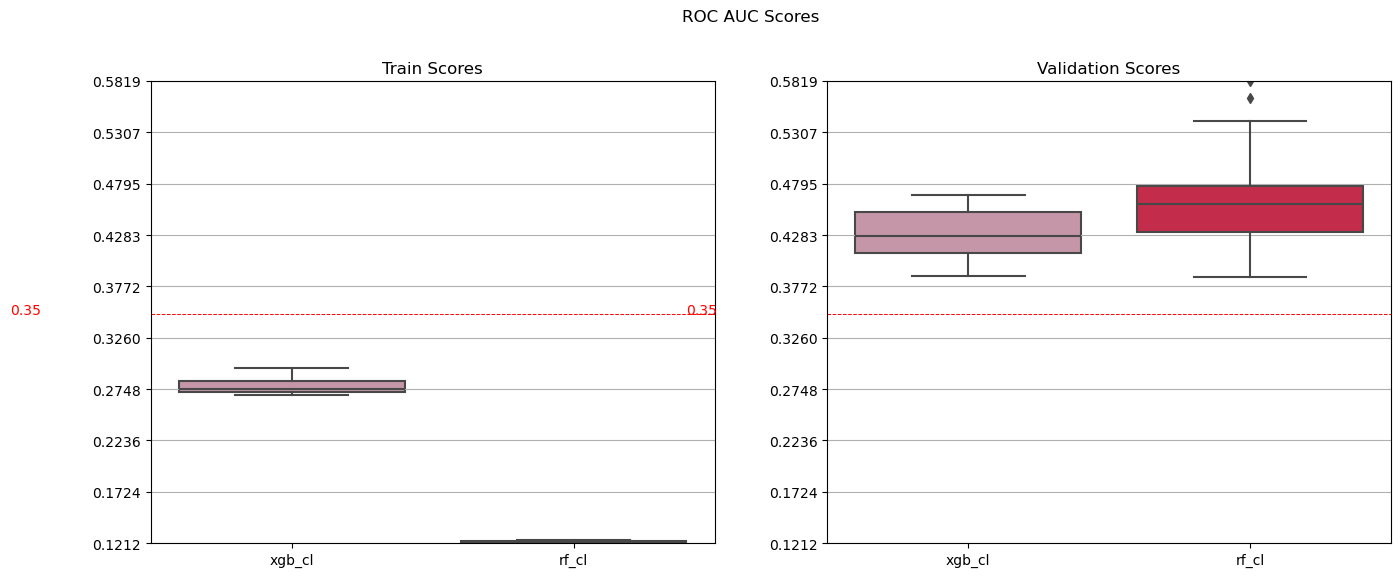

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

eps = .05
hl = .35
min_score = train_scores.min().min()
print(min_score)
max_score = val_scores.max().max()
print(max_score)
def calculate_ticks(min_score, max_score, num_ticks=10):
    return np.linspace(min_score, max_score, num_ticks)

ticks = calculate_ticks(min_score, max_score)

_ = sns.boxplot(train_scores, ax=axes[0])
_ = axes[0].set_title('Train Scores')
_ = axes[0].set_ylim(min_score, max_score)
_ = axes[0].set_yticks(ticks)
_ = axes[0].yaxis.grid(True)
_ = axes[0].axhline(y=hl, color='r', linestyle='--', lw=.7)
_ = axes[0].text(-1, hl, f"{hl}", c="red")

_ = sns.boxplot(val_scores, ax=axes[1])
_ = axes[1].set_title('Validation Scores')
_ = axes[1].set_ylim(min_score, max_score)
_ = axes[1].set_yticks(ticks)
_ = axes[1].yaxis.grid(True)
_ = axes[1].axhline(y=hl, color='r', linestyle='--', lw=.7)
_ = axes[1].text(-1, hl, f"{hl}", c="red")

fig.suptitle("ROC AUC Scores", y=1)  # Add a common title above the subplots
plt.show()


       XGB Train  XGB Validation   RF Train  RF Validation
count  30.000000       30.000000  30.000000      30.000000
mean    0.277652        0.430198   0.122633       0.465501
std     0.007563        0.024710   0.000811       0.045803
min     0.268652        0.387613   0.121246       0.386125
25%     0.271517        0.410736   0.121974       0.431321
50%     0.275108        0.427729   0.122461       0.459691
75%     0.282734        0.451251   0.123360       0.477486
max     0.296226        0.468661   0.124491       0.581875


/Users/josebaincera/miniforge3/envs/envMaster2/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/josebaincera/miniforge3/envs/envMaster2/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


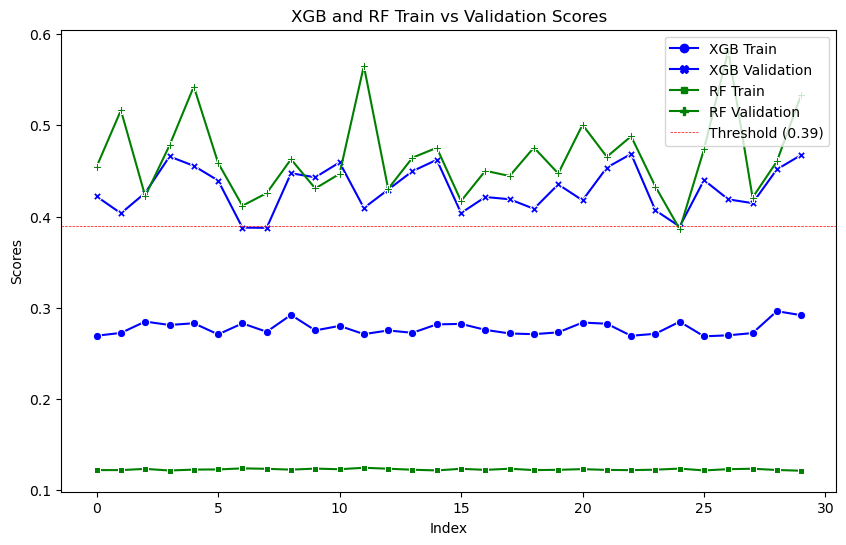

In [59]:
# Assuming `train_scores` and `val_scores` are DataFrames with scores for each model

# Separate the scores for xgb_cl and rf_cl models
xgb_train_scores = train_scores["xgb_cl"]
xgb_val_scores = val_scores["xgb_cl"]
rf_train_scores = train_scores["rf_cl"]
rf_val_scores = val_scores["rf_cl"]

# Print results in DataFrame
model_res = pd.concat([xgb_train_scores.describe(), xgb_val_scores.describe(), rf_train_scores.describe(), rf_val_scores.describe()], axis=1)
model_res.columns = ['XGB Train', 'XGB Validation', 'RF Train', 'RF Validation']
print(model_res)

# Plot results as lineplot
plt.figure(figsize=(10, 6))
_ = sns.lineplot(data=pd.concat([xgb_train_scores, xgb_val_scores, rf_train_scores, rf_val_scores], keys=["XGB Train", "XGB Validation", "RF Train", "RF Validation"], axis=1), markers=True, dashes=False, palette=["blue", "blue", "green", "green"])
plt.axhline(y=0.39, color='r', linestyle='--', lw=.5, label='Threshold (0.39)')

# Set the same color for both lines in the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(loc='upper right')

plt.title('XGB and RF Train vs Validation Scores')
plt.xlabel('Index')
plt.ylabel('Scores')
plt.show()


In [55]:
class MyAvgVoting(BaseEstimator, ClassifierMixin):
    """A basic voting method that just averages all estimator predictions and 
    predicts the class with the highest vote."""
    def __init__(self, estimators, weighted=False):
        self.estimators = estimators
        # Whether to average according to validation scores
        self.weighted = weighted

    def fit(self, X, y):
        for _, est in self.estimators:
            est["model"].fit(X, y)
        return self
    
    def create_avg_prob_predictions(self, X):
        predictions = np.array([est["model"].predict_proba(X) for est in self.estimators])
        if self.weighted:
            # Note: we need the inverse of the val_score since lower values are "better"
            weights = [{"name": est["name"], "value": 1/est["avg_val_score"]} for est in self.estimators]
            print(f"Weights are:\n{pd.DataFrame(weights)}")
            return np.average(predictions, axis=0, weights=[w["value"] for w in weights])
        return np.average(predictions, axis=0)
            
    def predict(self, X):
        avg_predictions = self.create_avg_prob_predictions(X)
        return np.argmax(avg_predictions, axis=1)

    def predict_proba(self, X):
        avg_predictions = self.create_avg_prob_predictions(X)
        return avg_predictions

    def score(self, X, y):
        pass

voting_ests = models
voting_clf = MyAvgVoting(voting_ests, weighted=False) 
# no fitting needed

In [79]:
voting_clf.estimators[1]

{'name': 'rf_cl',
 'model': RandomForestClassifier(class_weight={0: 1, 1: 2, 2: 1}),
 'feats': ['Platelets',
  'Copper',
  'Alk_Phos',
  'Diagnosis_Date',
  'SGOT',
  'Age',
  'N_Days',
  'Cholesterol',
  'Tryglicerides',
  'Albumin',
  'Bilirubin',
  'Prothrombin',
  'Symptom_Score',
  'Stage'],
 'avg_val_score': 0.4655014184846708}

In [85]:
# Classification report for all models in models
for model in models:
    y_pred_train = model['model'].predict(df_train_final[model['feats']])
    y_pred_test = model['model'].predict(df_test_final[model['feats']])
    print(f"{model['name']}(): ")
    print(f"Classification report Training: ")
    print(classification_report(df_train_final[LABEL],y_pred_train))
    print(f"\nClassification Report Testing: ")
    print(classification_report(df_test_final[LABEL],y_pred_test))
    print()


xgb_cl(): 
Classification report Training: 
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1865
           1       0.97      0.91      0.94      1200
           2       0.89      0.89      0.89      1865

    accuracy                           0.90      4930
   macro avg       0.91      0.90      0.91      4930
weighted avg       0.90      0.90      0.90      4930


Classification Report Testing: 
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1490
           1       0.33      0.32      0.32        82
           2       0.73      0.81      0.77       800

    accuracy                           0.81      2372
   macro avg       0.65      0.66      0.65      2372
weighted avg       0.82      0.81      0.81      2372


rf_cl(): 
Classification report Training: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1865
        

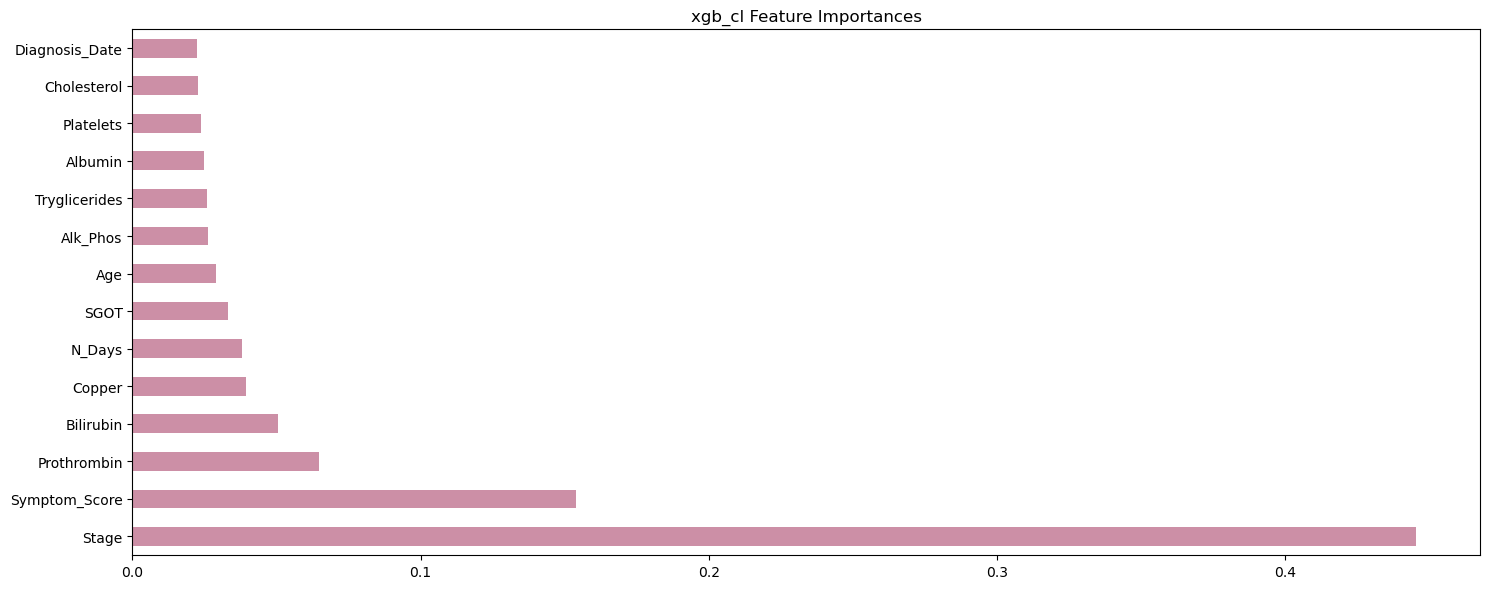

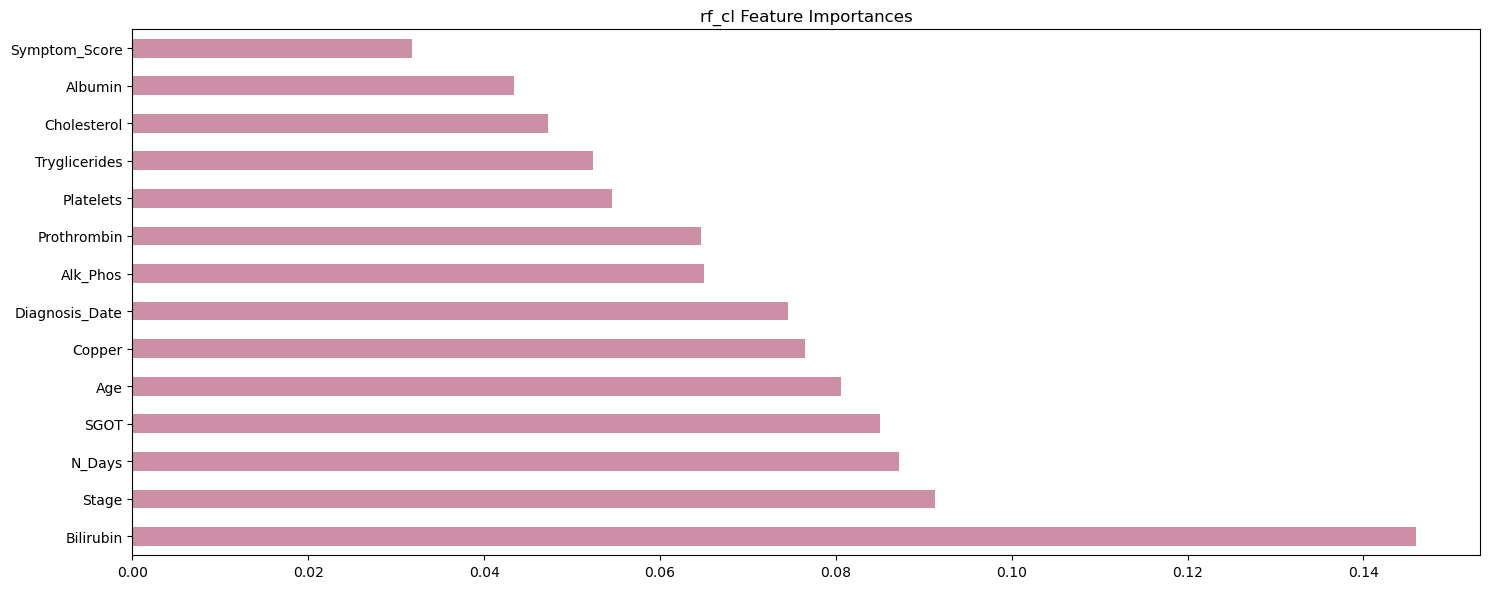

In [84]:
for model in models:
    feat_importances = pd.Series(model['model'].feature_importances_, index=df_train_final[FEATS].columns)

    # Plotting both feature importances in subplots
    fig, axes = plt.subplots(1, 1, figsize=(15, 6))

    feat_importances.nlargest(20).plot(kind='barh', title=f"{model['name']} Feature Importances")

    plt.tight_layout()
    plt.show()
    # print(f"Total sorted  importances: {feat_importances.nlargest(99).index.tolist()}")